## Import PDF Document

In [1]:
!pip install -U torch
!pip install PyMuPDF
!pip install tqdm
!pip install sentence-transformers
!pip install accelerate
!pip install bitsandbytes
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text):
    return text.replace("\n", " ").strip()

def read_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_num, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({
            "page_number": page_num-25,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count": len(text.split(". ")),
            "page_token_count": len(text)/4,
            "text": text
        })

    return pages_and_texts

pdf = "data.pdf"
pages_and_texts = read_pdf(pdf)

0it [00:00, ?it/s]

In [4]:
pages_and_texts[26:29]

[{'page_number': 1,
  'page_char_count': 43,
  'page_word_count': 7,
  'page_sentence_count': 1,
  'page_token_count': 10.75,
  'text': 'PART I The Fundamentals of Machine Learning'},
 {'page_number': 2,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': 3,
  'page_char_count': 1954,
  'page_word_count': 331,
  'page_sentence_count': 12,
  'page_token_count': 488.5,
  'text': 'CHAPTER 1 The Machine Learning Landscape With Early Release ebooks, you get books in their earliest form— the author’s raw and unedited content as he or she writes—so you can take advantage of these technologies long before the official release of these titles. The following will be Chapter 1 in the final release of the book. When most people hear “Machine Learning,” they picture a robot: a dependable but‐ ler or a deadly Terminator depending on who you ask. But Machine Learning is not just a futuristic fantasy, it’s already here.

## Splitting Pages into Sentences

#### Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

In [5]:
from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/510 [00:00<?, ?it/s]

In [6]:
import random
random.sample(pages_and_texts, k=1)

[{'page_number': 73,
  'page_char_count': 2429,
  'page_word_count': 390,
  'page_sentence_count': 17,
  'page_token_count': 607.25,
  'text': 'transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason. Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). How‐ ever, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn

In [7]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,510.00,510.00,510.00,510.00,510.00,510.00
mean,229.50,1904.96,359.86,13.93,476.24,14.14
std,147.37,709.47,379.68,12.16,177.37,6.67
min,-25.00,0.00,1.00,1.00,0.00,0.00
25%,102.25,1491.50,251.25,10.00,372.88,10.00
50%,229.50,1942.00,322.50,12.00,485.50,13.00
75%,356.75,2378.75,397.50,16.00,594.69,17.00
max,484.00,4854.00,3870.00,160.00,1213.50,53.00


## Chunking the sentences together

#### Why do we do this?

* Easier to manage similar sized chunks of text.
* Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
* Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.


**On average each of our pages has 13 sentences.**

**And an average total of 476 tokens per page.**

In [8]:
num_sentence_chunk_size = 13

def split_list(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(item["sentences"], num_sentence_chunk_size)
    item["sentence_chunk_count"] = len(item["sentence_chunks"])

  0%|          | 0/510 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 169,
  'page_char_count': 1621,
  'page_word_count': 304,
  'page_sentence_count': 12,
  'page_token_count': 405.25,
  'text': '5 To learn more about Quadratic Programming, you can start by reading Stephen Boyd and Lieven Vanden‐ berghe, Convex Optimization (Cambridge, UK: Cambridge University Press, 2004) or watch Richard Brown’s series of video lectures. off between these two objectives. This gives us the constrained optimization problem in Equation 5-4. Equation 5-4. Soft margin linear SVM classifier objective minimize w, b, ζ 1 2wTw + C ∑ i = 1 m ζ i subject to t i wTx i + b ≥1 −ζ i and ζ i ≥0 for i = 1, 2, ⋯, m Quadratic Programming The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as Quadratic Program‐ ming (QP) problems. Many off-the-shelf solvers are available to solve QP problems using a variety of techniques that are outside the scope of this book.5 The general problem for

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,sentence_chunk_count
count,510.00,510.00,510.00,510.00,510.00,510.00,510.00
mean,229.50,1904.96,359.86,13.93,476.24,14.14,1.52
std,147.37,709.47,379.68,12.16,177.37,6.67,0.65
min,-25.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,102.25,1491.50,251.25,10.00,372.88,10.00,1.00
50%,229.50,1942.00,322.50,12.00,485.50,13.00,1.00
75%,356.75,2378.75,397.50,16.00,594.69,17.00,2.00
max,484.00,4854.00,3870.00,160.00,1213.50,53.00,5.00


## Splitting each chunk into its own item

In [11]:
import re

pages_and_chunks = []
for item in pages_and_texts:
    for chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        join_chunk = " ".join(chunk).replace("  ", " ").strip()
        join_chunk = re.sub(r'\.([A-Z])', r'. \1', join_chunk)
        chunk_dict['sentence_chunk'] = join_chunk

        chunk_dict["chunk_char_count"] = len(join_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in join_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(join_chunk)/4

        pages_and_chunks.append(chunk_dict)

print("Total number of chunks -> ", len(pages_and_chunks))

Total number of chunks ->  776


In [12]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 471,
  'sentence_chunk': 'Object Detection | 471',
  'chunk_char_count': 22,
  'chunk_word_count': 4,
  'chunk_token_count': 5.5}]

In [13]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,776.00,776.00,776.00,776.00
mean,243.19,1230.37,215.25,307.59
std,146.25,682.86,188.75,170.71
min,-23.00,2.00,1.00,0.50
25%,116.75,653.75,110.75,163.44
50%,257.50,1316.00,217.00,329.00
75%,368.00,1739.25,287.00,434.81
max,484.00,3070.00,2048.00,767.50


In [14]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 0.75 | Text: | 5
Chunk token count: 10.0 | Text: Main Challenges of Machine Learning | 29
Chunk token count: 22.25 | Text: AdaGrad algorithm 1 . s s + ∇θJ θ ⊗∇θJ θ 2 . θ θ −η ∇θJ θ ⊘ s + � Faster Optimizers | 347
Chunk token count: 10.0 | Text: 174 | Chapter 5: Support Vector Machines
Chunk token count: 22.25 | Text: To compute the BIC and AIC, just call the bic() or aic() methods: Gaussian Mixtures | 269


In [15]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 254,
  'sentence_chunk': 'Using Clustering for Semi-Supervised Learning Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. Let’s train a logistic regression model on a sample of 50 labeled instances from the digits dataset: n_labeled = 50 log_reg = LogisticRegression() log_reg.fit(X_train[:n_labeled], y_train[:n_labeled]) What is the performance of this model on the test set? >>> log_reg.score(X_test, y_test) 0.8266666666666667 The accuracy is just 82.7%: it should come as no surprise that this is much lower than earlier, when we trained the model on the full training set. Let’s see how we can do better. First, let’s cluster the training set into 50 clusters, then for each cluster let’s find the image closest to the centroid. We will call these images the representative images: k = 50 kmeans = KMeans(n_clusters=k) X_digits_dist = kmeans.fit_transform(X_train) representative_digit_id

In [16]:
df = pd.DataFrame(pages_and_chunks_over_min_token_len)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,735.00,735.00,735.00,735.00
mean,245.20,1295.83,226.62,323.96
std,145.51,641.16,187.51,160.29
min,-23.00,122.00,17.00,30.50
25%,119.50,798.00,127.00,199.50
50%,260.00,1372.00,227.00,343.00
75%,368.50,1754.50,290.00,438.62
max,484.00,3070.00,2048.00,767.50


## Embedding our text chunks

In [17]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [18]:
%%time
embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/735 [00:00<?, ?it/s]

CPU times: user 18.8 s, sys: 397 ms, total: 19.2 s
Wall time: 20.2 s


In [19]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [20]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 13.9 s, sys: 31 ms, total: 13.9 s
Wall time: 13.5 s


tensor([[ 0.0117,  0.0103, -0.0419,  ...,  0.0483,  0.0019, -0.0060],
        [ 0.0164,  0.0330, -0.0472,  ...,  0.0040, -0.0021, -0.0074],
        [-0.0084,  0.0370, -0.0240,  ...,  0.0063,  0.0201, -0.0004],
        ...,
        [-0.0063,  0.0647, -0.0178,  ...,  0.0347,  0.0062, -0.0044],
        [ 0.0010,  0.0245, -0.0274,  ...,  0.0417,  0.0028, -0.0445],
        [ 0.0372,  0.0600,  0.0033,  ...,  0.0376,  0.0153, -0.0261]],
       device='cuda:0')

In [21]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "embeddings.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [22]:
embeddings_df_load = pd.read_csv("embeddings.csv")
embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-23,Aurélien Géron Hands-on Machine Learning with ...,237,30,59.25,[ 1.17405811e-02 1.02557745e-02 -4.18610796e-...
1,-22,978-1-492-03264-9 [LSI] Hands-on Machine Learn...,1854,256,463.50,[ 1.64178591e-02 3.29600535e-02 -4.72298674e-...
2,-21,Table of Contents Preface. . . . . . . . . . ....,1920,1124,480.00,[-8.44929460e-03 3.69615965e-02 -2.39553060e-...
3,-20,Frame the Problem ...,3070,2008,767.50,[ 1.89206377e-02 6.21086406e-03 -5.03808893e-...
4,-19,Multilabel Classification ...,3030,2048,757.50,[ 1.24200583e-02 -8.22364725e-03 -2.19620913e-...


## Similarity search

In [23]:
import torch
import numpy as np
import pandas as pd

embeddings_df = pd.read_csv("embeddings.csv")
embeddings_df['embedding'] = embeddings_df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = embeddings_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(embeddings_df["embedding"].tolist()), dtype=torch.float32).to("cuda")
embeddings.shape

torch.Size([735, 768])

In [24]:
embeddings_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-23,Aurélien Géron Hands-on Machine Learning with ...,237,30,59.25,"[0.0117405811, 0.0102557745, -0.0418610796, 0...."
1,-22,978-1-492-03264-9 [LSI] Hands-on Machine Learn...,1854,256,463.50,"[0.0164178591, 0.0329600535, -0.0472298674, 0...."
2,-21,Table of Contents Preface. . . . . . . . . . ....,1920,1124,480.00,"[-0.0084492946, 0.0369615965, -0.023955306, 0...."
3,-20,Frame the Problem ...,3070,2008,767.50,"[0.0189206377, 0.00621086406, -0.0503808893, -..."
4,-19,Multilabel Classification ...,3030,2048,757.50,"[0.0124200583, -0.00822364725, -0.0219620913, ..."


In [25]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")

In [26]:
query = "Loading and Preprocessing Data with TensorFlow"
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

torch.return_types.topk(
values=tensor([0.7080, 0.6897, 0.6752, 0.6646, 0.6478], device='cuda:0'),
indices=tensor([612, 628, 626, 655, 625], device='cuda:0'))

In [27]:
import textwrap

def print_wrapped(text, wrap_length=150):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [28]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")

    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])

    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Loading and Preprocessing Data with TensorFlow'

Results:
Score: 0.7080
Text:
CHAPTER 13 Loading and Preprocessing Data with TensorFlow With Early Release ebooks, you get books in their earliest form— the author’s raw and
unedited content as he or she writes—so you can take advantage of these technologies long before the official release of these titles. The following
will be Chapter 13 in the final release of the book. So far we have used only datasets that fit in memory, but Deep Learning systems are often trained
on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep
Learning libraries, but TensorFlow makes it easy thanks to the Data API: you just create a data‐ set object, tell it where to get the data, then
transform it in any way you want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching,
and so on. Off the shel

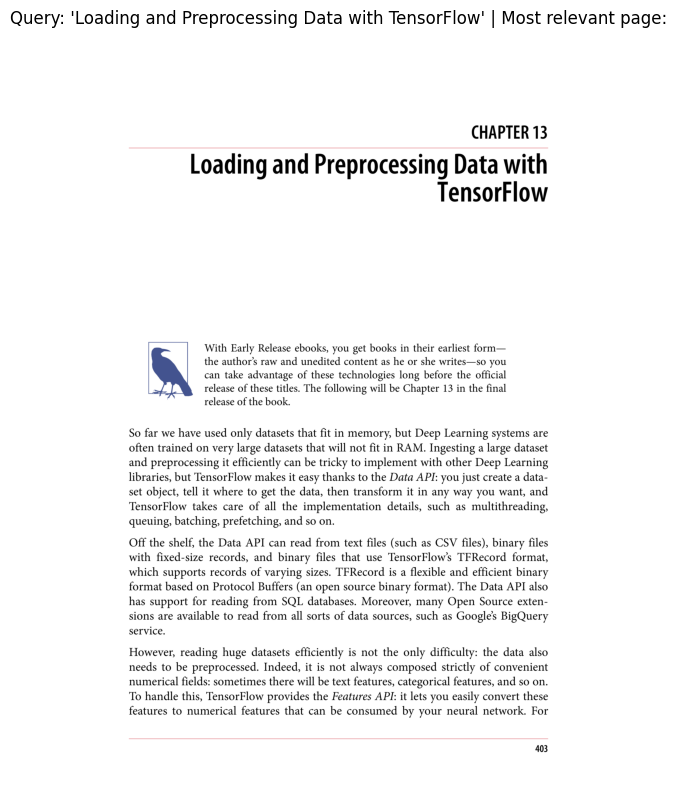

In [29]:
import fitz
import matplotlib.pyplot as plt
import numpy as np

pdf = "data.pdf"
doc = fitz.open(pdf)
page = doc.load_page(403 + 25)

img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [30]:
def retrieve(query, embeddings, model: SentenceTransformer=embedding_model, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    dot_scores = util.dot_score(query_embedding, embeddings)[0]

    scores, indices = torch.topk(input=dot_scores, k=top_k)

    return scores, indices

def print_top_results(query, embeddings, pages_and_chunks=pages_and_chunks, top_k=5):
    scores, indices = retrieve(query, embeddings, top_k=top_k)

    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [31]:
query = "Tensorflow"

scores, indices = retrieve(query, embeddings)
scores, indices

(tensor([0.6804, 0.6495, 0.6139, 0.6089, 0.6038], device='cuda:0'),
 tensor([ 31,   8,  12, 548, 550], device='cuda:0'))

In [32]:
print_top_results(query=query, embeddings=embeddings)

Query: Tensorflow

Results:
Score: 0.6804
This book also benefited from plenty of help from members of the TensorFlow team, in particular Martin Wicke, who tirelessly answered dozens of my
questions and dis‐ patched the rest to the right people, including Alexandre Passos, Allen Lavoie, André Susano Pinto, Anna Revinskaya, Anthony
Platanios, Clemens Mewald, Dan Moldo‐ van, Daniel Dobson, Dustin Tran, Edd Wilder-James, Goldie Gadde, Jiri Simsa, Kar‐ mel Allison, Nick Felt, Paige
Bailey, Pete Warden (who also reviewed the 1st edition), Ryan Sepassi, Sandeep Gupta, Sean Morgan, Todd Wang, Tom O’Malley, William Chargin, and
Yuefeng Zhou, all of whom were tremendously helpful. A huge thank you to all of you, and to all other members of the TensorFlow team. Not just for
your help, but also for making such a great library. Big thanks to Haesun Park, who gave me plenty of excellent feedback and caught sev‐ eral errors
while he was writing the Korean translation of the 1st edition of this book.

## Loading Local LLM

In [33]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

model_id = 'google/gemma-2b-it'
print(f"[INFO] Using model_id: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=None,
                                                 low_cpu_mem_usage=False)

llm_model.to("cuda")

[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [38]:
input_text = "What is Tensorflow and what is it used mainly for?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is Tensorflow and what is it used mainly for?

Prompt (formatted):
<bos><start_of_turn>user
What is Tensorflow and what is it used mainly for?<end_of_turn>
<start_of_turn>model



In [39]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)

print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,  54482,   5644,
            578,   1212,    603,    665,   1671,  13791,    604, 235336,    107,
            108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,  54482,   5644,
           578,   1212,    603,    665,   1671,  13791,    604, 235336,    107,
           108,    106,   2516,    108,    688,  32314,  15310,    688,    603,
           671,   2174, 235290,   2757,   6479,   6044,   9581,   6990,    731,
          6238,  16481, 235265,   1165,    603,   1671,    604,    476,   5396,
          3001,    576,   6479,   6044,  13333, 235269,   3359, 235292,    109,
           688,   6377, 148678,  66058,    109, 235287,   5231,  32314,  15310,
           603,  17022,   1671,   

In [40]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is Tensorflow and what is it used mainly for?<end_of_turn>
<start_of_turn>model
**TensorFlow** is an open-source machine learning library developed by Google AI. It is used for a wide range of machine learning tasks, including:

**Main Purposes:**

* **TensorFlow is primarily used for building and training machine learning models.** It provides a comprehensive set of tools and algorithms for data preparation, model building, training, evaluation, and deployment.
* **TensorFlow is widely used in various industries, including healthcare, finance, retail, and science.** It is a popular choice for building and training deep learning models, which are known to achieve state-of-the-art performance in various tasks.
* **TensorFlow is open-source and free to use.** This makes it accessible to a wide range of developers and organizations.
* **TensorFlow is constantly evolving and improving.** Google releases new features and updates reg

In [41]:
query_list = ["What are the main steps in a typical machine learning project pipeline?",
              "Explain the difference between supervised and unsupervised learning.",
              "What is the purpose of feature scaling, and how does it benefit machine learning algorithms?",
              "Describe the concept of cross-validation and its importance in model evaluation.",
              "What is overfitting, and how can it be addressed?",
              "Explain the bias-variance tradeoff in machine learning.",
              "What are the key components of a neural network?",
              "How does backpropagation work in neural networks?",
              "Describe the role of activation functions in neural networks.",
              "What are some common loss functions used in regression and classification tasks?"]

In [42]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

scores, indices = retrieve(query=query, embeddings=embeddings)
scores, indices

Query: Explain the bias-variance tradeoff in machine learning.


(tensor([0.6789, 0.4660, 0.4656, 0.4635, 0.4612], device='cuda:0'),
 tensor([203, 179,  75, 281, 178], device='cuda:0'))

## Augmenting prompt with context items

In [43]:
def prompt_formatter(query, context_items):
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

  with open("prompt.txt", "r") as file:
    base_prompt = file.read()

  base_prompt = base_prompt.format(context=context, query=query)

  dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

  prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                        tokenize=False,
                                        add_generation_prompt=True)

  return prompt

In [44]:
query = random.choice(query_list)
print(f"Query: ", query)

scores, indices = retrieve(query, embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query, context_items)
print(prompt)

Query:  What is the purpose of feature scaling, and how does it benefit machine learning algorithms?
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the main steps in a typical machine learning project pipeline?
Answer: The main steps in a typical machine learning project pipeline include data collection and cleaning, feature engineering, model selection and training, model evaluation, and deployment..

Example 2:
Query: Describe the concept of cross-validation and its importance in model evaluation.
Answer: Cross-validation is a technique used to evaluate the performance of a machine learning model. It involves splitting the dataset into multip

In [45]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids, temperature=0.7, do_sample=True, max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

Query: What is the purpose of feature scaling, and how does it benefit machine learning algorithms?
RAG answer:\m<bos>The purpose of feature scaling is to improve the performance of machine learning algorithms by reducing the variance of the features. By centering the features around zero and dividing them by the standard deviation, feature scaling makes the features have zero mean and unit variance, which can help to reduce overfitting. This leads to more accurate and robust predictions.<eos>
CPU times: user 3.13 s, sys: 28.6 ms, total: 3.16 s
Wall time: 3.24 s


In [46]:
def ask(query, temperature=0.7, max_new_tokens=512):
  scores, indices = retrieve(query=query, embeddings=embeddings)

  context_items = [pages_and_chunks[i] for i in indices]
  for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

  prompt = prompt_formatter(query=query, context_items=context_items)
  input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

  outputs = llm_model.generate(**input_ids, temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)
  output_text = tokenizer.decode(outputs[0])

  output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

  return output_text


In [53]:
while True:
    query = input("Enter your query: ")

    answer = ask(query=query, temperature=0.7, max_new_tokens=512)

    print(f"Answer:\n")
    print_wrapped(answer)

    user_input = input("\nDo you want to ask another question? (y/n): ").lower()
    if user_input != 'y':
        break

Enter your query: What are the main types of machine learning algorithms, and how do they differ?
Answer:

Sure, here's the answer to the user's query:  **Main Types of Machine Learning Algorithms:**  - Supervised Learning: The training data includes the
desired solutions (labels) of the dataset.  - Unsupervised Learning: The training data is unlabeled, and the algorithm discovers patterns and
relationships in the data.  - Semi-Supervised Learning: The training data has a combination of labeled and unlabeled data.  - Reinforcement Learning:
The agent learns through trial and error by receiving feedback from the environment.

Do you want to ask another question? (y/n): y
Enter your query: Explain the concept of regularization and its role in preventing overfitting.
Answer:

Sure, here's the explanation of regularization and its role in preventing overfitting from the context:  **Regularization** is a technique used to
reduce overfitting in machine learning models by forcing the model to

In [56]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

import locale
print(locale.getpreferredencoding())

!pip install -q gradio

UTF-8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.8 MB/s eta 0:00:00


In [63]:
import gradio as gr

def ask_and_respond(query):
    answer = ask(query=query, temperature=0.7, max_new_tokens=512)
    return answer

iface = gr.Interface(
    fn=ask_and_respond,
    inputs="text",
    outputs="text",
    title="MLBot",
    description='Hello, I am trained on "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" book.',
    examples=[
        ["What are the main types of machine learning algorithms, and how do they differ?"],
        ["Describe the process of hyperparameter tuning and its importance in model optimization."],
        ["What are some common loss functions used in regression and classification tasks?"]
    ]
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://393107a98613ce9f20.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
